In [1]:
from __future__ import absolute_import, division, print_function

#!pip install tf-nightly-2.0-preview
import tensorflow as tf
# tf.enable_eager_execution()

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import functools
import sys

/home/bdri/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bdri/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bdri/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bdri/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
import os
import tensorflow as tf
import xml.etree.ElementTree
import numpy as np

image_folder = ''
annotation_folder = ''

def maybe_download():
    image_zip = 'NLMCXR_png.tgz'
    if not os.path.exists(os.path.abspath('.') + '/dataset/' + image_zip):
        tf.keras.utils.get_file('NLMCXR_png.tgz',
                                cache_subdir=os.path.abspath('.') + '/dataset/',
                                origin = 'https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz',
                                extract = True)
        tf.keras.utils.get_file('NLMCXR_reports.tgz',
                                cache_subdir=os.path.abspath('.') + '/dataset/',
                                origin = 'https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz',
                                extract = True)

    global image_folder, annotation_folder
    image_folder = './dataset/'
    annotation_folder = './dataset/ecgen-radiology/'

def extract_data():
    all_findings = []
    all_impressions = []
    all_img_names = []
    rids = []

    total_count = 0 # Count of reports available in the dataset
    no_image_count = 0 # Count of reports having no associated chest image
    no_impression_count = 0 # Count of reports having an empty "Impression" section
    no_findings_count = 0 # Count of reports having an empty "Findings" section

    # Storing impressions, findings and the image names in vectors
    for file in os.listdir(annotation_folder):
        total_count += 1
        file = os.path.abspath(annotation_folder) + '/' + file
        e = xml.etree.ElementTree.parse(file).getroot()

        rid = e.find('pmcId').get('id') # Report Id
        # We choose to ignore reports having no associated image
        image_id = e.find('parentImage')
        if image_id is None:
            no_image_count += 1
            continue

        image_id = image_id.get('id')
        image_name = os.path.abspath('.') + '/' + image_id + '.png'
        findings = ''
        impression = ''

        # Parsing "Impression" and "Findings"
        for element in e.findall('MedlineCitation/Article/Abstract/AbstractText'):
            if element.get('Label') == 'FINDINGS':
                findings = element.text
            if element.get('Label') == 'IMPRESSION':
                impression = element.text

        # Sanity check: Skip this report if it has an empty "Impression" section
        if findings is None:
            no_findings_count += 1
            #findings = 'No finding'
            continue
        if impression is None:
            no_impression_count += 1
            continue

        # Transforming findings and impressions into lists of sentences
        findings = findings.replace("XXXX", "") #"XXXX" represents information anonymized
        sentences = findings.split('.')
        del sentences[-1]
        sentences = ['<start> ' + sentence + ' <end>' for sentence in sentences]
        findings = sentences

        impression = impression.replace("XXXX", "") #"XXXX" represents information anonymized
        sentences = impression.split('.')
        del sentences[-1]
        sentences = ['<start> ' + sentence + ' <end>' for sentence in sentences]
        impression = sentences

        #appending to vectors
        all_img_names.append(image_name)
        all_findings.append(findings)
        all_impressions.append(impression)
        rids.append(rid)

    print("Number of reports available:", total_count)
    print("Number of reports selected:", len(all_img_names))
    print("Number of reports not having images (skipped):", no_image_count)
    print("Number of reports with Impression section empty (skipped):", no_impression_count)
    print("Number of reports with Findings section empty:", no_findings_count)
    print("Total skipped:", no_image_count + no_impression_count + no_findings_count)

    return all_findings, all_impressions, all_img_names, rids

def init_inception_model():
    # Initialize InceptionV3 and load the pretrained Imagenet weights
    image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                    weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output

    return tf.keras.Model(new_input, hidden_layer)

def transform_input(all_findings, all_impressions, max_paragraph_length, max_sentence_length):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

    findings_texts = [' '.join(findings) for findings in all_findings]
    impressions_texts = [' '.join(impression) for impression in all_impressions]
    tokenizer.fit_on_texts(findings_texts + impressions_texts)
    all_findings_seq = [tokenizer.texts_to_sequences(findings) for findings in all_findings]
    all_impressions_seq = [tokenizer.texts_to_sequences(impression) for impression in all_impressions]

    tokenizer.word_index['<pad>'] = 0

    # Adding empty sentence seqs to each paragraph to have a fixed length for each
    for findings in all_findings_seq:
        while len(findings) < max_paragraph_length:
            findings.append([0])
        if len(findings) > max_paragraph_length:
            del findings[max_paragraph_length:]

    for impressions in all_impressions_seq:
        while len(impressions) < max_paragraph_length:
            impressions.append([0])
        if len(impressions) > max_paragraph_length:
            del impressions[max_paragraph_length:]

    # Padding sequences
    pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
    findings_vector = [pad_sequences(findings, padding='post', maxlen=max_sentence_length) for findings in all_findings_seq]
    impressions_vector = [pad_sequences(impressions, padding='post', maxlen=max_sentence_length) for impressions in all_impressions_seq]

    #print(findings_vector[0])
    #print(impressions_vector[0])

    # Combining findings and impressions
    for i in range(len(findings_vector)):
        findings_vector[i] = np.concatenate((findings_vector[i], impressions_vector[i]))
    # Now, for a given batch "i", we can retrieve impressions = findings[i, max_paragraph_length:]
    #print(findings_vector[0])

    return tokenizer, findings_vector

In [6]:
image_folder = './dataset/'
annotation_folder = './dataset/ecgen-radiology/'

In [7]:
import tensorflow as tf
import numpy as np

def gru(units):
    return tf.keras.layers.GRU(units,
                             return_sequences=True,
                             return_state=True,
                             recurrent_activation='sigmoid',
                             recurrent_initializer='glorot_uniform')

class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, key, query):
        # features(CNN_encoder output) shape: (batch_size, 64, embedding_dim)

        #print("Key Shape:", key.shape)
        #print("Query Shape:", query.shape)

        score = tf.nn.tanh(self.W1(key) + self.W2(query))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights*key
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # initial shape: (batch_size, 64, 2048)
        # shape after passing through fc: (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class Sentence_Encoder(tf.keras.Model):
    def __init__(self, units):
        super(Sentence_Encoder, self).__init__()
        self.attention = BahdanauAttention(units)
        self.fc = tf.keras.layers.Dense(units)

    def call(self, hidden_states, features):
        # hidden_states: (batch_size, max_sentence_length, units + units)
        # features: (batch_size, 64, embedding_dim)
        features = tf.expand_dims(features, 1)
        features = tf.reshape(features, (features.shape[0], features.shape[1], -1))
        # context_vector: (batch_size, units + units)
        # word_weights: (batch_size, max_sentence_length)
        context_vector, word_weights = self.attention(hidden_states, features)
        # encoded_sentence: (batch_size, units)
        encoded_sentence = self.fc(context_vector)

        return encoded_sentence, word_weights

class Paragraph_Encoder(tf.keras.Model):
    def __init__(self, units):
        super(Paragraph_Encoder, self).__init__()
        self.attention = BahdanauAttention(units)

    def call(self, encoded_sentences, features):
        # encoded_sentences: (batch_size, MAX_PARAGRAPH_LENGTH, units)
        # features: (batch_size, 64, embedding_dim)
        features = tf.expand_dims(features, 1)
        features = tf.reshape(features, (features.shape[0], features.shape[1], -1))
        # encoded_paragraph: (batch_size, units)
        # sentence_weights: (batch_size, MAX_PARAGRAPH_LENGTH)
        encoded_paragraph, sentence_weights = self.attention(encoded_sentences, features)
        return encoded_paragraph, sentence_weights

class Word_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Word_Decoder, self).__init__()

        self.attention = BahdanauAttention(units)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(units)
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, prev_sentence, hidden):
        # x: (batch_size, 1)
        # features: (batch_size, 64, embedding_dim)
        # prev_sentence: (batch_size, units)
        # hidden: (batch_size, units)

        # visual_context: (batch_size, embedding)
        # visual_weights: (batch_size, 64)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        visual_context, visual_weights = self.attention(features, hidden_with_time_axis)

        # x shape after passing through embedding: (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation:(batch_size, 1, embedding_dim + embedding_dim + units)
        x = tf.concat([tf.expand_dims(visual_context, 1), tf.expand_dims(prev_sentence, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        # output: (batch_size, 1, units)
        output, state = self.gru(x)
        # shape: (batch_size, 1, units)
        x = self.fc1(output)
        # x shape: (batch_size * 1, units)
        x = tf.reshape(x, (-1, x.shape[2]))
        # output shape: (batch_size * 1, vocab_size)
        x = self.fc2(x)

        return x, state, visual_weights

class Trainer():
    def __init__(self, tokenizer, embedding_dim, units):
        self.tokenizer = tokenizer
        self.units = units

        self.image_encoder = CNN_Encoder(embedding_dim)
        self.sentence_encoder = Sentence_Encoder(units)
        self.paragraph_encoder = Paragraph_Encoder(units)
        self.fwd_decoder = Word_Decoder(embedding_dim, units, len(tokenizer.word_index))
        self.bwd_decoder = Word_Decoder(embedding_dim, units, len(tokenizer.word_index))

    def loss_function(self, real, pred):
        mask = 1 - np.equal(real, 0)
        loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
        return tf.reduce_mean(loss_)

    def tensors_are_same(self, a, b):
        r = str(tf.reduce_all(tf.equal(a, b))) # In a perfect world, I would just compare tf.reduce_all(tf.equal(a, b)).numpy()
        return r[10] == 'T'

    def train_word_decoder(self, batch_size, loss, features, findings, i, \
                           prev_sentence, fwd_hidden, bwd_hidden):
        is_training_impressions = (i >= int(findings.shape[1]/2))

        fwd_input = tf.expand_dims([self.tokenizer.word_index['<start>']] * batch_size, 1)
        bwd_input = tf.expand_dims([self.tokenizer.word_index['<pad>']] * batch_size, 1)
        hidden_states = tf.zeros((batch_size, 1, self.units + self.units)) # concatenated fwd and bwd hidden states

        for j in range(findings.shape[2]): # generate each word (each sentence has a fixed # of words)
            print("j", j)
            predictions, fwd_hidden, _ = self.fwd_decoder(fwd_input, features, prev_sentence, fwd_hidden)
            loss += self.loss_function(findings[:, i, j], predictions)
            fwd_input = tf.expand_dims(findings[:, i, j], 1)

            predictions, bwd_hidden, _ = self.bwd_decoder(bwd_input, features, prev_sentence, bwd_hidden)
            loss += self.loss_function(findings[:, i, -(j+1)], predictions)
            bwd_input = tf.expand_dims(findings[:, i, -(j+1)], 1)

            # Concat the bwd anf fwd hidden states
            # (batch_size, 1, units + units)
            if not is_training_impressions is True:
                hidden = tf.concat([tf.expand_dims(fwd_hidden, 1), tf.expand_dims(bwd_hidden, 1)], axis=-1)
                if self.tensors_are_same(hidden_states, tf.zeros((batch_size, 1, self.units + self.units))) is True:
                  hidden_states = hidden
                else:
                  hidden_states = tf.concat([hidden_states, hidden], axis = 1)

        if not is_training_impressions is True:
            prev_sentence, _ = self.sentence_encoder(hidden_states, features)
            print(hidden_states.shape, prev_sentence.shape)
        return loss, prev_sentence, fwd_hidden, bwd_hidden

    def train_fn(self, batch_size, img_tensor, findings):
        loss = 0
        with tf.GradientTape() as tape:
            features = self.image_encoder(img_tensor)
            encoded_sentences = tf.zeros((batch_size, 1, self.units))
            prev_sentence = tf.zeros((batch_size, self.units))
            fwd_hidden = tf.zeros((batch_size, self.units))
            bwd_hidden = tf.zeros((batch_size, self.units))
            # Generate Findings
            for i in range(int(findings.shape[1]/2)): # for each sentence in "findings" (each batch has a fixed # of sentences)
                print("-------------------------------------i:", i)
                loss, prev_sentence, fwd_hidden, bwd_hidden = self.train_word_decoder(batch_size, loss, features, findings, i, \
                                                                                      prev_sentence, fwd_hidden, bwd_hidden)
                if self.tensors_are_same(encoded_sentences, tf.zeros((batch_size, 1, self.units))) is True:
                    encoded_sentences = tf.expand_dims(prev_sentence, 1)
                else:
                    encoded_sentences = tf.concat([encoded_sentences, tf.expand_dims(prev_sentence, 1)], axis = 1)

            encoded_paragraph, _ = self.paragraph_encoder(encoded_sentences, features)

            # Generate Impressions
            prev_sentence = encoded_paragraph
            fwd_hidden = tf.zeros((batch_size, self.units))
            bwd_hidden = tf.zeros((batch_size, self.units))
            for i in range(int(findings.shape[1]/2), findings.shape[1]): # for each sentence in "impressions" (each batch has a fixed # of sentences)
                print("-------------------------------------i:", i)
                loss, _, fwd_hidden, bwd_hidden = self.train_word_decoder(batch_size, loss, features, findings, i, \
                                                                          prev_sentence, fwd_hidden, bwd_hidden)

        # Outside of "With tf.GradientTape()"
        variables = self.image_encoder.variables + self.sentence_encoder.variables + self.paragraph_encoder.variables + \
                    self.fwd_decoder.variables + self.bwd_decoder.variables

        gradients = tape.gradient(loss, variables)
        return loss, gradients, variables

In [0]:
maybe_download()

1114112/1112632 [==============================] - 0s 0us/step


In [8]:
all_findings, all_impressions, all_img_names, rids=extract_data()

Number of reports available: 3955
Number of reports selected: 3331
Number of reports not having images (skipped): 104
Number of reports with Impression section empty (skipped): 6
Number of reports with Findings section empty: 514
Total skipped: 624


In [11]:
all_findings[10]

['<start> The lungs are clear <end>',
 '<start>  There is no pleural effusion <end>',
 '<start>  The heart and mediastinum are normal  <end>',
 '<start>  The skeletal structures and soft tissues are normal <end>']

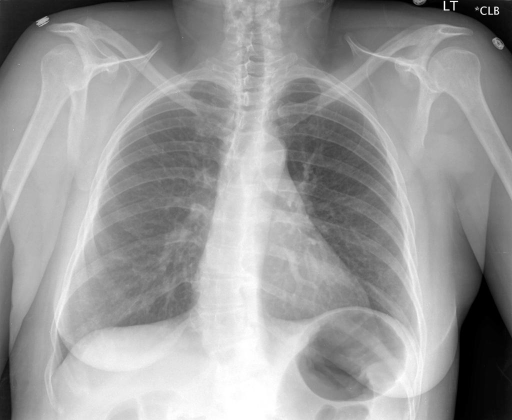

In [15]:
from IPython.display import Image
Image('dataset/content/CXR2813_IM-1239-1001.png')

In [16]:
MAX_PARAGRAPH_LENGTH = 5 # Fixed max number of sentences per report. This value comes from preprocessing
MAX_SENTENCE_LENGTH = 18 # Fixed max number of words per sentence. This value comes from preprocessing
max_sentence_length=18
max_paragraph_length=5
tokenizer, findings_vector=transform_input(all_findings, all_impressions, max_paragraph_length, max_sentence_length)

In [17]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 1.13.1


In [18]:
inception_model = init_inception_model()

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 384s 4us/step


In [19]:
# Create training and validation sets using 80-20 split
img_name_train, img_name_test, findings_train, findings_test = train_test_split(all_img_names, findings_vector, test_size = 0.2, random_state = 0)

In [20]:
trainer = Trainer(tokenizer, embedding_dim=256, units=512)

In [21]:
FEATURES_SHAPE = 2048
ATTENTION_FEATURES_SHAPE = 64

In [22]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize_images(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

def map_func(img_name, findings):
    img, img_path = load_image(img_name)
    img = tf.expand_dims(img, 0)
    img_tensor = inception_model(img)
    img_tensor = tf.reshape(img_tensor,
                            (-1, img_tensor.shape[3]))

    return img_tensor, findings

def _set_shapes(images, findings):
    # Statically set tensors dimensions
    #print(images.get_shape(), findings.get_shape())
    images.set_shape(tf.TensorShape([ATTENTION_FEATURES_SHAPE, FEATURES_SHAPE]))
    findings.set_shape(findings.get_shape().merge_with(
            tf.TensorShape([MAX_PARAGRAPH_LENGTH + MAX_PARAGRAPH_LENGTH, MAX_SENTENCE_LENGTH])))
    return images, findings

def input_fn(params):
    batch_size = params['batch_size']
    _findings_train = np.asarray(findings_train)

    dataset = tf.data.Dataset.from_tensor_slices((img_name_train, _findings_train))

    dataset = dataset.map(lambda item1, item2: tf.py_func(
                map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=FLAGS.num_shards)

    #dataset = dataset.map(map_func)
    dataset = dataset.map(functools.partial(_set_shapes))

    # shuffling and batching
    dataset = dataset.shuffle(10000).repeat()
    # https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(1)
    # print("Dataset type:", dataset.output_shapes, dataset.output_types)
    return dataset

def model_fn(features, labels, mode, params):

    print("Model_Fn Shapes:", features.shape, labels.shape)
    print("Features:", features)
    batch_size = params['batch_size']

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
        loss, gradients, variables = trainer.train_fn(batch_size, features, labels)
        train_op = optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())

        return tf.contrib.tpu.TPUEstimatorSpec(mode=tf.estimator.ModeKeys.TRAIN,
                                               loss = loss,
                                               train_op = train_op)

In [23]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

## https://stackoverflow.com/questions/55318626/module-tensorflow-has-no-attribute-logging

In [24]:
tpu_zone=None
gcp_project=None
tpu=None

# tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
#         tpu,
#         zone=tpu_zone,
#         project=gcp_project
#     )

# batch_size= 1024
batch_size= 256


# train_steps=1000
train_steps=100
eval_steps=0
use_tpu=True
enable_predict= True
iterations_per_loop= 50
# num_shards= 8 
num_shards= 1


In [25]:
history=train(input_fn=input_fn, max_steps=train_steps)

NameError: name 'train' is not defined

In [0]:
trainer.